In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

In [44]:
class LDA:

    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discs = None

    def fit(self,X,y):
        n_features = X.shape[1]
        class_labels = np.unique(y)

        # S_W, S_B
        mean_overall = np.mean(X,axis=0) # (4,)
        S_W = np.zeros((n_features,n_features),dtype='complex') #(4,4)
        S_B = np.zeros((n_features,n_features),dtype='complex') #(4,4)

        for c in class_labels:
            X_c = X[y==c]
            mean_c = np.mean(X_c,axis=0) #(4,) # class mean
            # (4,n_c) * (n_c, 4) = (4,4) 
            S_W += (X_c - mean_c).T.dot((X_c - mean_c))  # within class scatter

            n_c = X_c.shape[0] # number of samples
            # (4,1) * (4,1).T = (4,4)
            mean_diff = (mean_c - mean_overall).reshape(n_features,1) # (4,1)
            S_B += n_c * (mean_diff).dot(mean_diff.T)  # between class scatter
        
        A = np.linalg.inv(S_W).dot(S_B) # matrix for calculating eigenvalues/vectors
        eigenvalues, eigenvectors = np.linalg.eig(A)
        eigenvectors = eigenvectors.T
        idxs = np.argsort(abs(eigenvalues))[::-1] # descending order
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        self.linear_discs = eigenvectors[0:self.n_components]

        

    def transform(self, X):
        # project data onto new components
        return np.dot(X,self.linear_discs.T)

In [12]:
import pandas as pd
from pathlib import Path
root = Path.cwd()

harv = pd.read_csv(root / 'output' / 'HARV' / f'tree_spectral_sigs_HARV.csv')
bart = pd.read_csv(root / 'output' / 'BART' / f'tree_spectral_sigs_BART.csv')

data = pd.concat([harv,bart],axis=0)

del(harv,bart)

In [13]:
# filter just numeric columns
data_filtered = data.iloc[:,1:427]
# convert column names to numeric
data_filtered.columns = np.round(data_filtered.columns.to_numpy().astype('float'),0).astype('int')

# remove noisy bands
bands = data_filtered.columns
hs_filters = [[410,1320],[1450,1800],[2050,2475]]
mask_list = [(bands>=lmin) & (bands<=lmax) for lmin, lmax in hs_filters]
band_mask = np.logical_or.reduce(mask_list)

data_filtered = data_filtered.loc[:,band_mask]

In [14]:
# replace tree codes with numbers
data['taxonID_codes'] = data['taxonID'].replace(np.unique(data['taxonID']),
                        np.array(np.arange(0,len(np.unique(data['taxonID'])),1)))

binary = [1 if x == 'FAGR' else 0 for x in np.unique(data['taxonID'])]
data['taxonID_codes_binary'] = data['taxonID'].replace(np.unique(data['taxonID']),binary)


C:\Users\roseh\AppData\Local\Temp\ipykernel_13004\2855852888.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['taxonID_codes'] = data['taxonID'].replace(np.unique(data['taxonID']),
C:\Users\roseh\AppData\Local\Temp\ipykernel_13004\2855852888.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['taxonID_codes_binary'] = data['taxonID'].replace(np.unique(data['taxonID']),binary)


In [ ]:


# define X and y
X = data_filtered.to_numpy() # as numpy array?
y = data['taxonID_codes_binary'].to_numpy()

# run lda
lda = LDA(2)
lda.fit(X,y)
X_projected = lda.transform(X)

x1, x2 = X_projected[:,0], X_projected[:,1]



c:\Users\roseh\miniconda3\envs\beech-env\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\roseh\miniconda3\envs\beech-env\Lib\site-packages\matplotlib\collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


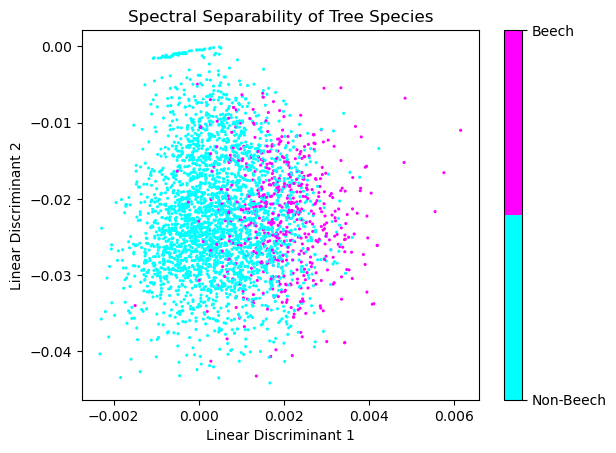

In [ ]:
x1, x2 = X_projected[:,0], X_projected[:,1]

cmap = plt.get_cmap("cool", len(np.unique(y)))

plt.scatter(x1,x2,c=y,s=1.5,cmap=cmap)

plt.xlabel("Linear Discriminant 1")
plt.ylabel("Linear Discriminant 2")
plt.colorbar(ticks=range(2)).set_ticklabels(['Non-Beech','Beech'])
plt.title('Spectral Separability of Tree Species')
plt.show()

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SequentialFeatureSelector
# test dataset
# data_iris = datasets.load_iris()
# X_iris = data_iris.data
# y_iris = data_iris.target

# diabetes = datasets.load_diabetes()
# X, y = diabetes.data, diabetes.target

X = data_filtered.to_numpy() # as numpy array?
y = data['taxonID_codes_binary'].to_numpy()

In [17]:
X.shape

(3502, 337)

In [48]:
lda = LinearDiscriminantAnalysis()

sfs_forward = SequentialFeatureSelector(
    lda, n_features_to_select=50, direction="forward"
).fit(X, y)

In [49]:
data_filtered.columns[sfs_forward.get_support()]

X_selected = X[:,sfs_forward.get_support()]

In [50]:
lda = LDA(2)

lda.fit(X_selected,y)

X_projected = lda.transform(X_selected)


c:\Users\roseh\miniconda3\envs\beech-env\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\roseh\miniconda3\envs\beech-env\Lib\site-packages\matplotlib\collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


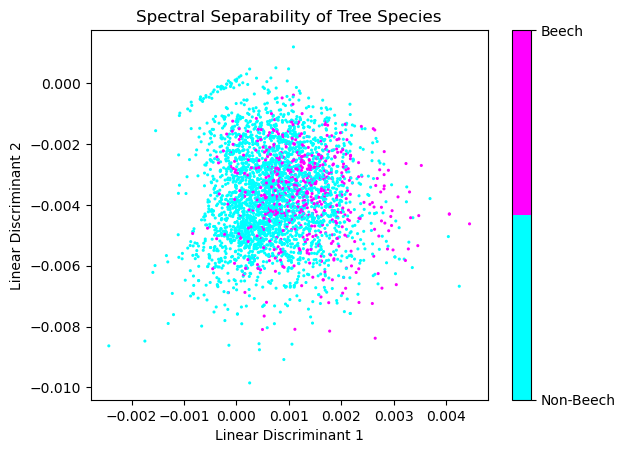

In [51]:
x1, x2 = X_projected[:,0], X_projected[:,1]

cmap = plt.get_cmap("cool", len(np.unique(y)))

plt.scatter(x1,x2,c=y,s=1.5,cmap=cmap)

plt.xlabel("Linear Discriminant 1")
plt.ylabel("Linear Discriminant 2")
plt.colorbar(ticks=range(2)).set_ticklabels(['Non-Beech','Beech'])
plt.title('Spectral Separability of Tree Species')
plt.show()